In [1]:
## Bring in needed mods
import numpy as np, pandas as pd
from matplotlib import pyplot as plt
import scipy.stats as ss, seaborn as sns
import sys
#sys.path.insert(0, '/../../QTL-functions/SCRIPTS/')
import qtlfunctions as QTLfun
import qtlmovie as QTLmovies

def allelic_manu(geno,pheno,x=0,y=1): ## geno and pheno need to be in the same position
    """
    Conducts a Mann-Whitney U test on the phenotype data in PHENO
    by the genotypic states listed in GENO.
    
    Assumes the order of data within GENO and PHENO are paired.
    Defaluts for the biallelic stat in GENO are 0 and 1; set in X and Y.
    
    Returns the -log10 of the calculated p-value
    """
    pheno = np.array(pheno) ## sets the type for the data as an array
    geno = np.array(geno)
    ## Gather phenotypes by genotypes 
    ## Parse the genotype data as True for 0 and then 1 and 
    ## take the asscoiated index within the phenotypic data array
    ## Return p-value
    return -np.log10(ss.mannwhitneyu(pheno[(geno==x)],pheno[(geno==y)])[1])

def allelic_ANOVA(site, pheno):
    """This regression is equivalent to one-way ANOVA with 2 groups. 
        Return F-statistic.
    """
    coding = np.array(site,np.float)
    pheno = np.array(pheno,np.float)

    meany = np.mean(pheno)
    meandummy = np.mean(coding)
    ctry = pheno - meany
    ctrdummy = coding - meandummy
    
    # regression coefficient and intercept
    b = np.dot(ctry, ctrdummy)/np.dot(ctrdummy, ctrdummy)
    intercept = meany - b * meandummy
    
    yhat = b * ctrdummy
    len_yhat = np.sqrt(np.dot(yhat,yhat))
    len_y = np.sqrt(np.dot(ctry,ctry))
    df_yhat = 1
    
    error = ctry  - yhat
    len_error = np.sqrt(np.dot(error,error))
    if abs(len_error**2) < 1e-5:
        raise Exception("Zero length error in ANOVA")
    df_error = len(pheno) - 2
    
    # coefficient of determination is R**2
    R = (len_yhat/len_y)**2
    
    # F-statistic
    F = (len_yhat**2/df_yhat) / (len_error**2/df_error)
    return F,R

def association_logPval(site, pheno):
    F,R = allelic_ANOVA(site, pheno)
    logP = np.log10(ss.f.sf(F, 1, len(pheno)-2))
    return -logP,R

# Data curation

In [2]:
## Load phentype data
data_path = '../../PHENOTYPE/XL280x431/XL280x431_cross_amoeba_roth_processed_01_26_2021.csv'
ph = pd.read_csv(data_path)

ph.drop('Unnamed: 0', axis = 1,inplace= True)

ph = ph[(ph.Replicate != 2)] # remove the second replicate; it does not correlate well with replicates 1 or 3

ph.head()

,Strain,Replicate,Stack,passage,plate,Area.1,Area.12,Sample
0,431alpha,1,2,10,p2_1,1.470965,11.658041,SS-A837
1,431alpha,1,1,11,p1_1,1.587094,17.741900,SS-A837
4,431alpha,3,1,9,2_3-1_3_secondhalf,2.419350,10.696753,SS-A837
5,431alpha,3,4,7,2_3-1_3_firsthalf,1.193546,14.083843,SS-A837
6,B307,1,3,10,p2_1,4.122572,30.490262,SS-B307


In [3]:
## Load genotype data
genotype_path = '../../GENOTYPE/CDx-ill-SNP-INDEL-df-104-blocked.csv.gz'
gv = pd.read_csv(genotype_path)
gv.head()

,Chrom,Pos,Qual,Callrate,Ref,Alt,Altlen,Dp,Type,Vcfix,...,SS-B598,SS-B565,SS-B600,SS-B574,SS-B872_cor,SS-B873_cor,SS-B360,SS-B397,SS-B564,SS-B382
0,Chr01,5016,104492.0,1.0,C,A,1,6510,snp,289,...,1.0,0.0,1.0,1.0,0.0,0.0,1.0,0.0,1.0,0.0
1,Chr01,5299,112647.0,1.0,T,C,1,9711,snp,293,...,1.0,0.0,1.0,1.0,0.0,0.0,1.0,0.0,1.0,0.0
2,Chr01,5464,112658.0,1.0,T,C,1,9375,snp,294,...,1.0,0.0,1.0,1.0,0.0,0.0,1.0,0.0,1.0,0.0
3,Chr01,6120,109003.0,1.0,T,C,1,9311,snp,311,...,1.0,0.0,1.0,1.0,0.0,0.0,1.0,0.0,1.0,0.0
4,Chr01,6166,114638.0,1.0,G,A,1,9269,snp,312,...,1.0,0.0,1.0,1.0,0.0,0.0,1.0,0.0,1.0,0.0


Strain_names = []
Dont_rep = []
for i,j in ph.iterrows():
    
    s = j.Strain
    
    if s in gv.columns:
        Strain_names.append(s)
    
    elif 'SS-'+s in gv.columns:
        Strain_names.append('SS-'+s)
            
    elif s == '431alpha':
        Strain_names.append('SS-A837')
    elif s == 'KN99':
        Strain_names.append('KN99')
    else:
        Dont_rep.append('SS-'+s)
        Strain_names.append(s)

print(len(Strain_names))
print(Strain_names[:10])

ph['Sample'] = Strain_names

for i,j in ph.iterrows():
    if not j.Strain == j.Sample.split('SS-')[-1]:
        print(j.Strain)

In [4]:
ph.head()

,Strain,Replicate,Stack,passage,plate,Area.1,Area.12,Sample
0,431alpha,1,2,10,p2_1,1.470965,11.658041,SS-A837
1,431alpha,1,1,11,p1_1,1.587094,17.741900,SS-A837
4,431alpha,3,1,9,2_3-1_3_secondhalf,2.419350,10.696753,SS-A837
5,431alpha,3,4,7,2_3-1_3_firsthalf,1.193546,14.083843,SS-A837
6,B307,1,3,10,p2_1,4.122572,30.490262,SS-B307


In [5]:
pheno = ph[(ph.Sample.isin(gv.columns))][['Sample','Area.12']]
pheno.columns = ['Sample','Area.12'] ## Rename column names


## Take mean phenotype per strain
mean_pheno = pheno.groupby('Sample').mean().sort_values('Area.12')
mean_pheno.shape

(104, 1)

In [6]:
mean_pheno.rename(columns = {"Area.12" : "Growth"}, inplace = True)

In [7]:
mean_pheno.tail()

,Growth
Sample,
SS-B350,36.438637
SS-B358,38.796697
SS-B317,38.932180
SS-B369,48.593451
SS-C039,54.812794


In [8]:
mean_pheno.dropna(inplace=True)

In [9]:
mean_pheno.shape

(104, 1)

In [10]:
mean_pheno.reset_index(inplace=True)

# Phenotype visulization and exploration

In [11]:
from matplotlib import rc
xl280alpha_label = r'$\bf{XL280}$'+r'$\alpha$'
xl280a_label = r'$\bf{XL280}$' +r'$\bf{a}$'
_431_label = r'$\bf{431}$'+r'$\mathrm{\alpha}$'

#myylabel = 'Area of clearance\nby amoeba (cm$^2$)\n$\longleftarrow$resistant - sensitive$\longrightarrow$'
myylabel = 'Amoeba clearance area (cm$^2$)\n$\longleftarrow$resistant - sensitive$\longrightarrow$'

In [12]:
parentals = ['SS-A837','XL280a']#,'XL280alpha']
parental_labels = [_431_label,xl280a_label]#,xl280alpha_label]

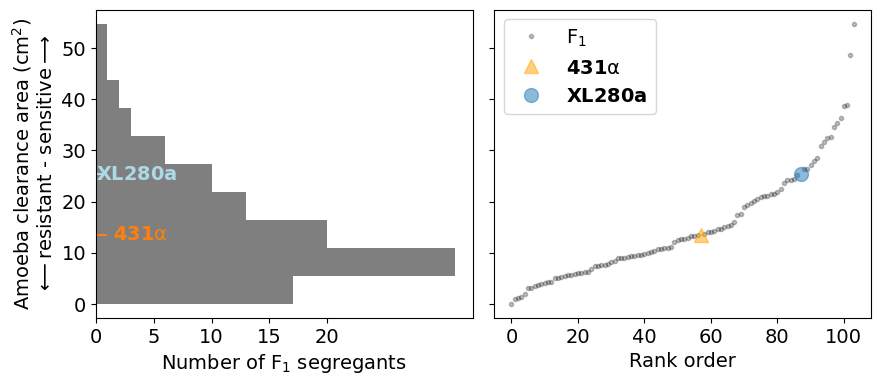

In [13]:
## Plot segregants
fig,ax = plt.subplots(1,2,figsize=(10,4),sharey=True)

plt.sca(ax[0])
## Plot all
plt.hist(mean_pheno.Growth.values,
         color='k',alpha=0.5,
         orientation='horizontal')
         
## Label x and y axis
plt.ylabel(myylabel,fontsize=14)
plt.xlabel('Number of F$_1$ segregants',fontsize=14);

## Plot parents

_431_growth = mean_pheno[(mean_pheno.Sample=='SS-A837')].Growth
plt.hlines(_431_growth,
           0,1,color='tab:orange',label=parental_labels[0])

## annotate the parental strain name
plt.text(1.5,_431_growth,s=parental_labels[0],
         va='center',ha='left',fontsize=14,color='tab:orange')


## Plot parents
xl280a_growth = mean_pheno[(mean_pheno.Sample=='XL280a')].Growth
plt.hlines(xl280a_growth,
           0,1,color='lightblue',label=parental_labels[1]);

## annotate the parental strain name
plt.text(3.5,xl280a_growth,s=parental_labels[1],
         va='center',ha='center',
         fontsize=14,color='lightblue');

plt.xticks(np.arange(0,25,5),fontsize=14)
plt.yticks(fontsize=14)
## Summon the legend
#plt.legend(fontsize=14);

plt.sca(ax[1])
plt.plot(mean_pheno[~(mean_pheno.Sample.isin(parentals))].index,
         mean_pheno[~(mean_pheno.Sample.isin(parentals))].Growth.values,
         'k.',alpha=0.25,label='F$_{1}$');


for i,p in enumerate(parentals):
    
    plt.plot(mean_pheno[(mean_pheno.Sample == p )].index,
         mean_pheno[(mean_pheno.Sample == p)].Growth.values,
         'o' if i ==1 else '^',alpha=0.5,label=parental_labels[i],
             color='orange' if p =='SS-A837' else 'tab:blue',ms=10);
    
plt.xlabel('Rank order',fontsize=14);
plt.xticks(fontsize=14)
#plt.ylabel(myylabel,
#           fontsize=14)
plt.legend(fontsize=14);
plt.subplots_adjust(wspace=0.058)
#plt.savefig('/home/croth/Bt22xFtc555-1/FIGURES/XL280x431_amoeba_assay.png',
#            dpi=150,bbox_inches='tight');

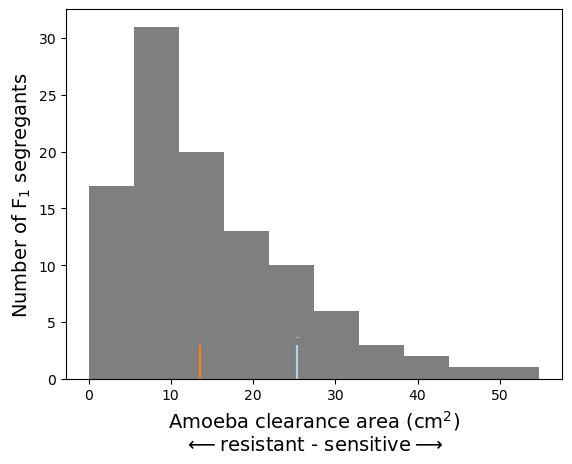

In [14]:
fs = 1

## Plot all
plt.hist(mean_pheno.Growth.values,
         color='k',alpha=0.5,label='$F_1$')
         
## Label x and y axis
plt.xlabel(myylabel,fontsize=14)
plt.ylabel('Number of F$_1$ segregants',fontsize=14);

## Plot parents

_431_growth = mean_pheno[(mean_pheno.Sample=='SS-A837')].Growth
plt.vlines(_431_growth,
           0,3,color='tab:orange',label=parental_labels[0])

## annotate the parental strain name
plt.text(_431_growth,3.5,s=parental_labels[0],
         va='bottom',ha='center',fontsize=fs,color='tab:orange')


## Plot parents
xl280a_growth = mean_pheno[(mean_pheno.Sample=='XL280a')].Growth
plt.vlines(xl280a_growth,
           0,3,color='lightblue',label=parental_labels[1]);

## annotate the parental strain name
plt.text(xl280a_growth,3.5,s=parental_labels[1],
         va='bottom',ha='center',fontsize=fs,color='lightblue');

plt.savefig('../../FIGURES/XL280x431_amoeba_assay_trim.png',
            dpi=150,bbox_inches='tight');

In [15]:
ss.shapiro(mean_pheno.Growth.values)

ShapiroResult(statistic=0.9118061065673828, pvalue=3.6186902434565127e-06)

In [16]:
ss.normaltest(mean_pheno.Growth.values)

NormaltestResult(statistic=23.27146863369584, pvalue=8.844327040550132e-06)

In [17]:
mean_pheno.head()

,Sample,Growth
0,SS-B580,0.006452
1,SS-C029_cor,0.980643
2,SS-B598,1.193546
3,SS-B570,1.309675
4,SS-B874,1.822577


In [18]:
Halo = mean_pheno.set_index('Sample')

high = Halo.sort_values("Growth").loc['XL280a'].values[0]

low = Halo.sort_values("Growth").loc['SS-A837'].values[0]

low, high

(13.5451342, 25.387045999999998)

In [19]:
low_segs = Halo[(Halo["Growth"] < low)].shape[0]

high_segs = Halo[(Halo["Growth"] > high)].shape[0]

total_segs = Halo.shape[0]



#Halo[Halo.PMY == test]
low_segs, total_segs, high_segs

(57, 104, 16)

In [20]:
positive = low_segs/ total_segs*100

negative = high_segs/total_segs *100

transg = low_segs/ total_segs*100 + high_segs/total_segs *100

non_transg = 100 - transg

positive, negative, transg, non_transg ## percentage of segregants displaying transgressive segregation

(54.807692307692314, 15.384615384615385, 70.1923076923077, 29.807692307692307)

# QTL Mapping

In [21]:
mapping_pop = mean_pheno.Sample.tolist()
len(mapping_pop)

104

In [22]:
## Gather unique loci
loci = gv[mapping_pop].drop_duplicates().copy()
loci.head()

,SS-B580,SS-C029_cor,SS-B598,SS-B570,SS-B874,SS-B407,SS-B374,SS-B383,SS-B929,SS-B553,...,SS-C036,SS-B310,SS-B569,SS-B908_cor,SS-B354,SS-B350,SS-B358,SS-B317,SS-B369,SS-C039
0,1.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,...,0.0,1.0,1.0,0.0,1.0,0.0,1.0,1.0,1.0,1.0
232,1.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,...,0.0,1.0,1.0,0.0,0.0,0.0,1.0,0.0,1.0,1.0
249,1.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,...,0.0,1.0,1.0,0.0,0.0,0.0,1.0,0.0,1.0,1.0
252,1.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,...,0.0,1.0,1.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0
254,1.0,0.0,1.0,1.0,1.0,0.0,1.0,0.0,0.0,0.0,...,0.0,1.0,1.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0


In [23]:
## Cunduct QTL mapping

loci['Pval'] = loci[mapping_pop].apply(allelic_manu,args=[mean_pheno.Growth.values],axis=1)
#loci['Pval'] = loci[mapping_pop].apply(crypto_kruskal,args=[mean_pheno.Growth.values],axis=1)

In [24]:
## Merge results
qtldf = gv.merge(loci)

In [25]:
## Set significance threshold for QTL mapping
## If this threshold is above zero 
## the cell below was previously run
## Set to -1 to re run calculation
threshold = 4.0533130044953705## 0.05 threshold

## Set permutations, 
## Gather phenotype into an array
## make list of permutated data.
perms = 1000
pheno = mean_pheno.Growth.values
perms_pheno = [np.random.permutation(pheno) for i in range(perms)]

## Gather loci and intiate null distrbution
loci = gv[mapping_pop].drop_duplicates() 

if threshold < 0:
    null = []
    i = 0
    while len(null) < perms:
        
        ## Permute the phenotypic space
        null.append(loci.apply(allelic_manu,
                               args=[perms_pheno[i]],
                               axis=1).max())
        i += 1 ## Add one to i
        
    ## Take the upper 95th percentile    
    threshold = np.percentile(null,95 if perms <= 1000 else 99)

In [26]:
threshold

4.0533130044953705

## Plot QTL

In [27]:
## Make a list of the unique chromosomes
chrlist = sorted(qtldf.Chrom.unique())
assert len(chrlist)==14
print(chrlist[:4])

['Chr01', 'Chr02', 'Chr03', 'Chr04']


In [28]:
## Estimate and gather maximum chromosome length
chrommap = qtldf.groupby('Chrom')['Pos'].max().reset_index()

chrommap['Cumlen'] = [0] + chrommap.Pos.cumsum().tolist()[:-1]
chrommap['Midpts'] = (chrommap.Pos.values/2) + chrommap.Cumlen.values

chrommap.head()

,Chrom,Pos,Cumlen,Midpts
0,Chr01,2295469,0,1147734.5
1,Chr02,1623022,2295469,3106980.0
2,Chr03,2100376,3918491,4968679.0
3,Chr04,1777939,6018867,6907836.5
4,Chr05,1451825,7796806,8522718.5


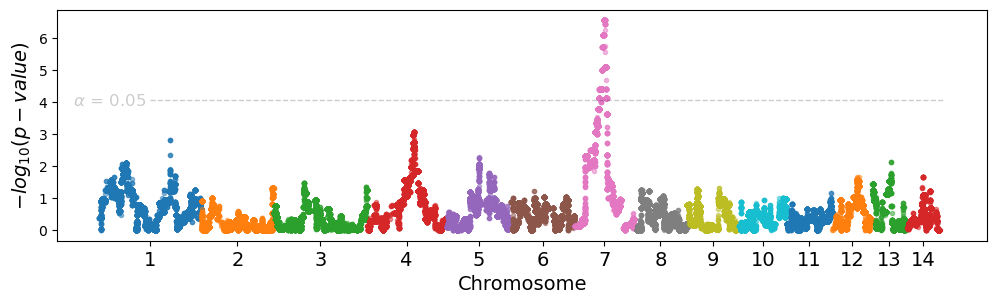

In [29]:
fig,ax = plt.subplots(1,1,figsize=(12,3))

for i,j in chrommap.iterrows():
    
    
    temp = qtldf[(qtldf.Chrom == j.Chrom)]
    
    plt.plot( temp.Pos.values+j.Cumlen, temp.Pval.values,'.',alpha=0.5);

plt.xticks(chrommap.Midpts.values, np.arange(1,15),fontsize=14)
plt.ylabel("$-log_{10}(p-value)$",fontsize=14);
plt.xlabel('Chromosome',fontsize=14);
plt.text(chrommap.Midpts.min()-100000,threshold,'$\u03B1$ = 0.05',
         fontsize=12,alpha=0.2,ha='right',va='center')
plt.hlines(threshold,chrommap.Midpts.min(),19*10**6,
           linestyle='--',linewidth=1,color='k',alpha=0.2);
plt.savefig('../../FIGURES/XL280x431_amoeba_assay_QTL_trim.png',
           dpi=200,bbox_inches='tight');
#ax1 = fig.add_axes([0.125,-0.75,.3,.1])

In [30]:
qtlix = qtldf.Pval.idxmax()
qtlchorm = qtldf.loc[qtlix,'Chrom']
qtlchorm

'Chr07'

In [31]:
temp = qtldf[(qtldf.Chrom == qtlchorm)]

In [32]:
mean_pheno['QTL'] = gv.loc[qtlix,mapping_pop].values

In [33]:
mean_pheno.head()

,Sample,Growth,QTL
0,SS-B580,0.006452,1.0
1,SS-C029_cor,0.980643,0.0
2,SS-B598,1.193546,1.0
3,SS-B570,1.309675,1.0
4,SS-B874,1.822577,0.0


In [34]:
import statsmodels.formula.api as smf, seaborn as sns

In [35]:
res = smf.ols('Growth~QTL',data=mean_pheno).fit()
res.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                 Growth   R-squared:                       0.226
Model:                            OLS   Adj. R-squared:                  0.219
Method:                 Least Squares   F-statistic:                     29.81
Date:                Thu, 29 Dec 2022   Prob (F-statistic):           3.36e-07
Time:                        11:24:52   Log-Likelihood:                -380.64
No. Observations:                 104   AIC:                             765.3
Df Residuals:                     102   BIC:                             770.6
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept     19.6358      1.247     15.750      0.000      17.163      22.109
QTL[T.1.0]   -10.2357      1.875     -5.460      0.000     -13.954      -6.517
==============================================================================
Omnibus:                       18.800   Durbin-Watson:                   0.485
Prob(Omnibus):                  0.000   Jarque-Bera (JB):               24.951
Skew:                           0.906   Prob(JB):                     3.82e-06
Kurtosis:                       4.573   Cond. No.                         2.50
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [36]:
-np.log10(res.pvalues[1])

6.473088224610354

In [37]:
r2 = np.round(res.rsquared,2)
r2

0.23

In [38]:
mean_pheno['QTL']=mean_pheno['QTL'].apply(float)

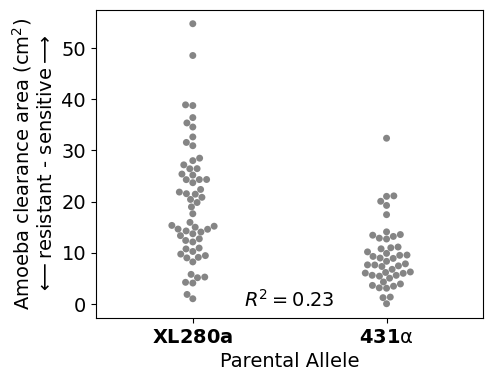

In [39]:
fig,ax = plt.subplots(1,1,figsize=(5,4))
#just_segs = mean_pheno[~(mean_pheno.Sample.isin(parental_labels[:2]))]
sns.swarmplot(x='QTL',y='Growth',data=mean_pheno,
              alpha=0.95,color='tab:grey');
#sns.regplot(x = "QTL", y = "Growth", data = mean_pheno, ci=False,
#            line_kws = {"alpha":0.8, "color":"red"}, 
#            scatter_kws = {"alpha":0});

#for gt in [0,1]:
#    plt.hlines(mean_pheno[(mean_pheno.QTL==gt)].Growth.mean(),
#           -0.2+gt,0.2+gt,linestyle='--',
#               color='blue' if gt == 0 else 'darkorange')

plt.text(0.5,0.8,'$R^2 = %s$'%r2,color='k',
         va='center',ha='center',fontsize=14)
plt.yticks(fontsize=14)
plt.ylabel(myylabel,fontsize=14)
plt.xlabel('Parental Allele',fontsize=14)
plt.xticks([0,1],parental_labels[:2][::-1],fontsize=14);
plt.savefig('../../FIGURES/XL280x431_amoeba_assay_genotype_by_phenotype_trim.png',
           dpi=150,bbox_inches='tight');

In [40]:
gene_changes = pd.read_csv('/home/croth/crypto-QTL-paper/DATA/XL280_431_gene_analysis.csv.gz')
gff = pd.read_csv('/home/croth/crypto-QTL-paper/DATA/xl280genome.gff3.csv.gz',index_col=0)

FileNotFoundError: [Errno 2] No such file or directory: '/home/croth/crypto-QTL-paper/DATA/XL280_431_gene_analysis.csv.gz'

## Boot strap phenotype and genotype on chromosome 7

In [ ]:
bsp = []
perms = 200
mean_pheno.index = mean_pheno.Sample
chrom = gv[(gv.Chrom==qtlchorm)
          ][mapping_pop+['Pos']].copy().reset_index(drop=True)

#for i in range(perms):
#    
#    bsegs = np.random.choice(mapping_pop,len(mapping_pop))
#    bpheno = mean_pheno.loc[bsegs,'Growth'].values
    
#    bloci = chrom[bsegs].drop_duplicates()
    
#    bloci['Pval'] = bloci.apply(association_logPval,args=[bpheno],axis=1)
        
#    bres = chrom.merge(bloci.T.drop_duplicates().T)
#    bres.sort_values('Pval',inplace=True)
    
#    bpos = bres[(bres.Pval==bres.Pval.max())].Pos.median()
#    bsp.append((bpos,bres.Pval.max()))
    
#bdf = pd.DataFrame(bsp,columns=['Pos','Pval'])

#qtl_ci = (np.percentile(bdf.Pos,5), np.percentile(bdf.Pos,95))
#qtl_ci

In [ ]:
changes = gene_changes.merge(gff[(gff.type=='gene')][
    ['gene','start','end','description','strand']]).sort_values('start').copy()

qtl_ci = (changes[(changes.gene=='CNG02235')].start.min(),changes[(changes.gene=='CNG02480')].end.max())

changes['description'] = [d.split('%2C')[0] for d in changes.description]

bad_description = ['hypothetical protein',
                   'conserved hypothetical protein',
                   'expressed protein']

hypoix = ~(changes.description.isin(bad_description))

qtl_genes_all = changes[(changes.start>=np.min(qtl_ci)) & 
                        (changes.end<=np.max(qtl_ci)) & 
                        (changes.chrom==qtlchorm)]
qtl_genes_all.shape

In [ ]:
recombci = pd.DataFrame(chrom[(chrom.Pos.isin(np.arange(np.min(qtl_ci),np.max(qtl_ci)+1)))].diff(axis=0).abs().sum()[:-1],columns=['Crossovers'])

qtl_recombinants = recombci[(recombci.Crossovers>0)].index.tolist()

qtl_recombinants_gt = chrom[(chrom.Pos.isin(np.arange(np.min(qtl_ci),np.max(qtl_ci)+1)))][qtl_recombinants+['Pos']]

sorted_recombinants = mean_pheno.loc[qtl_recombinants].sort_values('Growth').Sample.tolist()
sorted_growth = mean_pheno.loc[qtl_recombinants].sort_values('Growth').Growth.values

In [ ]:
centolocs = pd.read_csv('/home/croth/crypto-QTL-paper/DATA/XL280-centromere-locs.csv',index_col=0)
centolocs.columns = ['Left','Right']
centolocs.head()

In [ ]:
fig,ax = plt.subplots(2,1,figsize=(15,8),sharex=True)

ax1 = ax[0].twinx()  # instantiate a second axes that shares the same x-axis
plt.sca(ax1)
for i,j in qtl_genes_all.iterrows():
    
    ## Stop gain or stop loss
    if j.nonsense>0:
        mycolor= 'r'
    else:
        mycolor='k'
    
    ## invariant
    if j.description in bad_description:
        myalpha = 0.25
        myfontsize= 7
    else:
        myalpha = 1
        myfontsize=8
    
    ## strand
    if j.strand == '-':
        ymod = -1
        xmod = j.end
        hamod = 'left'
        
    else:
        ymod = 1
        xmod = j.start
        hamod = 'right'
    
    plt.hlines(j.missense+(0.15*ymod),j.start,j.end,color=mycolor,alpha=myalpha,linewidth=2);
    plt.text(xmod,j.missense+ymod,s=j.gene,
             ha='center',va='center',color=mycolor,alpha=myalpha,
             fontsize=myfontsize)
    

plt.ylabel('Number of\nnon-synonymous changes',fontsize=14)
    
    
    
## Plot QTL    
qtlax =  fig.add_axes([0.35,.95,.3,.2])

plt.sca(qtlax)
plt.plot(temp.Pos.values,temp.Pval.values,'.',color='tab:pink');

l,p = plt.xticks()

plt.xticks(l[1:-1][::2],[int(p) for p in l[1:-1][::2]]);
plt.ylabel("$-log_{10}(p-value)$",fontsize=14);

plt.plot(np.mean([1047647,1048359]), 0.5,'k.')


plt.hlines(0,*qtl_ci,'k')
plt.vlines(qtl_ci,-0.2,0.2,color='k');

plt.hlines(0,np.min(centolocs.T[qtlchorm].values),
             np.max(centolocs.T[qtlchorm].values),
           color='k',alpha=0.5,linewidth=4);

ax1.spines['top'].set_visible(False)
#ax.spines['top'].set_visible(False)


boxs = [[0.491,.88,.00000003,.07],[0.507,.88,.0000003,.07],[0.4915,.85,0.015,0.11]]
for i,b in enumerate(boxs):
    axl = fig.add_axes(b)
    plt.sca(axl)
    plt.yticks([])
    plt.xticks([])
    if i > 1:
        [axl.spines[a].set_visible(False) for a in ['top','left','right','bottom']]
        
## Plot the QTL peak
plt.sca(ax[0])
peak = temp[(temp.Pos>=np.min(qtl_ci)) & (temp.Pos<=np.max(qtl_ci))]
plt.plot(peak.Pos,peak.Pval,'.',color='tab:pink')
plt.ylabel("$-log_{10}(p-value)$",fontsize=14)


plt.sca(ax[1])


plt.xlabel('Chomosome %s Coordinates'%int(qtlchorm[-2:]),fontsize=14);
for i,c in enumerate(sorted_recombinants):
    
    _431 = qtl_recombinants_gt[(qtl_recombinants_gt[c]==0)][[c,'Pos']]
    _xl280  = qtl_recombinants_gt[(qtl_recombinants_gt[c]==1)][[c,'Pos']]

    plt.plot(_431.Pos,i*np.ones(_431.Pos.shape),'.',color='tab:orange');
    plt.plot(_xl280.Pos,i*np.ones(_xl280.Pos.shape),'.',color='tab:blue');
    
    plt.text(630000,i+0.2,s=''.join(c.split('-')),
             va='center',ha='left',fontsize=10)
    
plt.yticks(np.arange(len(sorted_growth)),[str(g) for g in np.round(sorted_growth,2)]);
plt.ylabel(myylabel,fontsize=14)
plt.subplots_adjust(hspace=0.1)
ax[1].spines['top'].set_visible(False)



plt.savefig('/home/croth/Bt22xFtc555-1/FIGURES/XL280x431_amoeba_assay_chromosome_%s_QTL_ZOOM.png'%int(qtlchorm[-2:]),
            dpi=300,bbox_inches='tight')

In [ ]:
qtl_genes_all

In [ ]:
qtl_ci

In [ ]:
mean_pheno.loc[qtl_recombinants].sort_values('Growth')

fine_mapped = pd.read_csv('/home/croth/Documents/Ameoba_chromosome_7_QTL_Finemapped.csv',
                         index_col=0)
fine_segs = sorted(fine_mapped.columns.tolist()[5:])

fine_mapped.head()

fig,ax = plt.subplots(2,1,figsize=(15,8),sharex=True)

ax1 = ax[0].twinx()  # instantiate a second axes that shares the same x-axis
plt.sca(ax1)
for i,j in qtl_genes_all.iterrows():
    
    ## Stop gain or stop loss
    if j.nonsense>0:
        mycolor= 'r'
    else:
        mycolor='k'
    
    ## invariant
    if j.description in bad_description:
        myalpha = 0.25
        myfontsize= 7
    else:
        myalpha = 1
        myfontsize=8
    
    ## strand
    if j.strand == '-':
        ymod = -1
        xmod = j.end
        hamod = 'left'
        
    else:
        ymod = 1
        xmod = j.start
        hamod = 'right'
    
    plt.hlines(j.missense+(0.15*ymod),j.start,j.end,color=mycolor,alpha=myalpha,linewidth=2);
    plt.text(xmod,j.missense+ymod,s=j.gene,
             ha='center',va='center',color=mycolor,alpha=myalpha,
             fontsize=myfontsize)
    

plt.ylabel('Number of\nnon-synonymous changes',fontsize=14)
    
## Plot the QTL peak
plt.sca(ax[0])
peak = temp[(temp.Pos>=np.min(qtl_ci)) & (temp.Pos<=np.max(qtl_ci))]
plt.plot(peak.Pos,peak.Pval,'.',color='tab:pink')
plt.ylabel("$-log_{10}(p-value)$",fontsize=14)


plt.sca(ax[1])


plt.xlabel('Chomosome %s Coordinates'%int(qtlchorm[-2:]),fontsize=14);
for i,c in enumerate(fine_segs):
    
    _431 = fine_mapped[(fine_mapped[c]==0)][[c,'Pos']]
    _xl280  = fine_mapped[(fine_mapped[c]==1)][[c,'Pos']]

    plt.plot(_431.Pos,i*np.ones(_431.Pos.shape),'.',color='tab:orange');
    plt.plot(_xl280.Pos,i*np.ones(_xl280.Pos.shape),'.',color='tab:blue');
    
    plt.text(630000,i+0.12,s='$F_1$ %s'%c,
             va='center',ha='left',fontsize=10)
    
#plt.yticks(np.arange(len(sorted_growth)),[str(g) 
#                             for g in np.round(sorted_growth,2)]);
#plt.ylabel(myylabel,fontsize=14)
plt.subplots_adjust(hspace=0.1)
ax[1].spines['top'].set_visible(False)
plt.yticks([])

plt.savefig('../Desktop/Fine_mapped_chromosome_%s_QTL_ZOOM.pdf'%int(qtlchorm[-2:]),
            dpi=300,bbox_inches='tight')

# Initial Exploration

In [ ]:
plt.plot(ph['Area.1'].values,ph['Area.12'].values,'.');
plt.xlabel('Area day 1');plt.ylabel('Area day 12 - day 1');
fig,ax = plt.subplots(2,1,figsize=(10,10),sharex=True)
plt.sca(ax[0])
plt.hist(ph['Area.1'].values);
plt.sca(ax[1])
plt.hist(ph['Area.12'].values);

In [ ]:
len(Dont_rep)
print(Dont_rep)

In [ ]:
open('./DONT_REPLICATE_XL280_431.csv','w').writelines('\n'.join(Dont_rep))

In [ ]:
gv_samples = [c for c in gv.columns 
              if c[:3]=='SS-'] + ['XL280a','XL280alpha']
len(gv_samples)

In [ ]:
[s for s in Dont_rep if s in gv.columns]

In [ ]:
missing_samples = [s for s in gv_samples if s not in Strain_names]
print(len(missing_samples))
print(missing_samples)

## SS-B621 failed cracked plate
## SSS-B587 contamonatied
## The remaning did not grow

In [ ]:
ph.loc[[i for i in ph.index.tolist() if i not in ph.dropna().index],]

In [ ]:
ph[(ph.Strain.isin(['B961','B580','B586','B906_cor']))]

In [ ]:
'SS-B580' in gv_samples

In [ ]:
'SS-B961' in gv_samples